In [309]:
import requests
import datetime
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
def to_date(s):
    dt = datetime.datetime.utcfromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d")
def get_visit_list(s):
    data={}
    data['visit_list'] = s['用户ID'].tolist()
    return pd.Series(data)
def get_buy_rate(s):
    data={}
    data['buy_list'] = s['会员ID'].tolist()
    return pd.Series(data)

def user_rebuy_plot(date,visit_times):
    dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [
                                                   {'id': {'terms': {'field': 'id'}}},

                                                  ]}}},
                 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': date,
                                                              'lte': date,
                                                              'time_zone': '+00:00'}}}]}}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_user_table', doc_type='user', body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
    df1 = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))
    
    dsl11 = {
        'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id', 'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [{"用户ID": {"terms": {"field": 'user_id'}}},
                                       ]}}},
         'query': {'bool': {'must': [{'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=1))[:10],
                                                    'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=7))[:10],
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'user_id': df1['id'].tolist()}},
                        ]}}}
    es11 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res11 = es11.search(index='shop_pv_event', doc_type='pv_event', body=dsl11,
                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                    search_type='query_then_fetch')
    df11 = json_normalize(res11['aggregations']['my_buckets']['buckets'])
    df11.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df11.columns))
                                                      
    active_list = []
    for i in range(len(df11)):
        if df11.iloc[i]['打开(Visitor).value']>=visit_times:                                          ####访问次数调整
            active_list.append(df11.iloc[i]['用户ID'])
        
    dead_list = list(set(df1['id'].tolist())-set(active_list))
    
    return dead_list

def get_order_list(s):
    data={}
    data['order_list'] = s['用户ID'].tolist()
    return pd.Series(data)


def number_and_list(date, split_number,visit_times):
    dead_list = user_rebuy_plot(date,visit_times)
    dsl_list = {
                'query': {'bool': {'must': [
                                            {'terms': {'user_id': dead_list}},
                                            {'terms': {'order_status': ['confirmed',
                                                                        'done',
                                                                        'fulfilled']}},
                                            {'range': {'paytime': {'format': 'yyyy-MM-dd',
                                                              'gte': date,
                                                              'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=7))[:10],
                                                              'time_zone': '+00:00'}}},
                                            ]}},
                "aggs": {
                    "my_buckets": {
                        "composite": {
                            'size': 9999999,
                            "sources": [{"用户ID": {"terms": {"field": 'user_id'}}},
                                #{"单价": {"terms": {"field": 'skutotal_price'}}}
                                ]}}}}
    es_list = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res_list = es_list.search(index='es_order_table', doc_type='order', body=dsl_list,
                            _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                            search_type='query_then_fetch')
    df_list = json_normalize(res_list['aggregations']['my_buckets']['buckets'])
    df_list.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_list.columns))
    
    target_user_list_c=[]
    for i in range(len(df_list)):
        if df_list.iloc[i]['doc_count'] > split_number:                           
            target_user_list_c.append(df_list.iloc[i]['用户ID'])
        #else:
        #    continue
    
    target_user_list = list(set(dead_list)-set(target_user_list_c))
    
    return target_user_list

In [117]:
date = '2019-05-31'
user_red_list,date_index_list,length=[],[],[]
for i in range(10):
    date_index=str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=i))[:10]
    date_index_list.append(date_index)
    length.append(len(number_and_list(date_index, 1,3)))
    user_red_list.append(number_and_list(date_index, 1,3))
    
val = {'date_index':date_index_list,'人数':length,'user_red':user_red_list}
red_list=pd.DataFrame(val)

In [118]:
red_list.head()

,date_index,人数,user_red
0,2019-05-31,1686,"[851968, 851969, 851972, 696327, 851977, 85198..."
1,2019-06-01,1701,"[860160, 860164, 856073, 860173, 860176, 85608..."
2,2019-06-02,1376,"[864264, 864270, 598044, 860240, 860242, 86025..."
3,2019-06-03,1265,"[647176, 864273, 864274, 864275, 864276, 86427..."
4,2019-06-04,1274,"[868352, 868356, 868360, 868361, 868363, 86836..."


多项式回归

In [275]:
date = '2019-05-31'
people_list=number_and_list(date, 1,3)
dsl ={'aggs': {'my_buckets': {'aggregations': {},
                             'composite': {'size': 9999999,
                                           'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '1d',
                                                                                  'time_zone': '+00:00'}}},
                                                       {'会员ID':{'terms':{'field':'user_id'}}},
                                                       ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'gte': date, 
                                                        'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=7))[:10], 
                                                         'format': 'yyyy-MM-dd', 'time_zone': '+00:00'}}}, 
                                 {'terms':{'user_id': people_list}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                search_type='query_then_fetch')
df = json_normalize(res['aggregations']['my_buckets']['buckets'])
df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
df['日期'] = df['日期'].apply(to_date)

df_date=df.groupby('日期').apply(get_buy_rate)

In [276]:
for i in range(len(df_date)-1):
    if str(datetime.datetime.strptime(df_date.index[i],'%Y-%m-%d')+datetime.timedelta(days=1))[:10] not in df_date.index:
        df_date.loc[str(datetime.datetime.strptime(df_date.index[i],'%Y-%m-%d')+datetime.timedelta(days=1))[:10]]= [[]]
df_date=df_date.reset_index()
df_date=df_date.sort_values(by=['日期'])

In [277]:
df_date=df_date.reset_index()

In [278]:
df_date

,index,日期,buy_list
0,0,2019-05-31,"[285573, 309289, 339761, 429083, 433373, 43562..."
1,1,2019-06-01,"[389402, 661612, 850721, 852073, 853622, 85372..."
2,2,2019-06-02,"[565081, 683807, 716061, 851495, 851633, 85171..."
3,3,2019-06-03,"[541620, 851621, 851868, 851870, 851918, 85203..."
4,4,2019-06-04,"[851652, 851915]"
5,5,2019-06-05,"[850765, 851011, 852857]"
6,6,2019-06-06,"[522967, 850548, 851010, 851274, 853711]"
7,7,2019-06-07,"[735788, 852024, 852822, 853710]"


In [279]:
df_date=df_date.drop(['index'],axis=1)

In [280]:
df_date

,日期,buy_list
0,2019-05-31,"[285573, 309289, 339761, 429083, 433373, 43562..."
1,2019-06-01,"[389402, 661612, 850721, 852073, 853622, 85372..."
2,2019-06-02,"[565081, 683807, 716061, 851495, 851633, 85171..."
3,2019-06-03,"[541620, 851621, 851868, 851870, 851918, 85203..."
4,2019-06-04,"[851652, 851915]"
5,2019-06-05,"[850765, 851011, 852857]"
6,2019-06-06,"[522967, 850548, 851010, 851274, 853711]"
7,2019-06-07,"[735788, 852024, 852822, 853710]"


In [303]:
number,percentage=[],[]
for i in range(len(df_date)):
    number.append(len(df_date.iloc[i]['buy_list']))
    percentage.append(len(df_date.iloc[i]['buy_list'])/len(red_list.iloc[0]['user_red']))
df_date['人数']=number
df_date['百分比']=percentage

In [304]:
df_date

,日期,buy_list,人数,百分比
0,2019-05-31,"[285573, 309289, 339761, 429083, 433373, 43562...",801,0.475089
1,2019-06-01,"[389402, 661612, 850721, 852073, 853622, 85372...",7,0.004152
2,2019-06-02,"[565081, 683807, 716061, 851495, 851633, 85171...",8,0.004745
3,2019-06-03,"[541620, 851621, 851868, 851870, 851918, 85203...",10,0.005931
4,2019-06-04,"[851652, 851915]",2,0.001186
5,2019-06-05,"[850765, 851011, 852857]",3,0.001779
6,2019-06-06,"[522967, 850548, 851010, 851274, 853711]",5,0.002966
7,2019-06-07,"[735788, 852024, 852822, 853710]",4,0.002372


In [316]:
coeff = np.polyfit(df_date.index,np.log1p(df_date['百分比']),3)
coeff

array([-0.0067264 ,  0.08663725, -0.32947432,  0.34767077])

In [317]:
day=df_date.index[-1]+1
value=coeff[0]*day**3+coeff[1]*day*2+coeff[2]*day**1+coeff[3]*day**0
value

-4.345844269420185

In [319]:
start=0 #输入需要绘制的起始值（从左到右）
stop=8 #输入需要绘制的终点值
step=0.1#输入步长
num=(stop-start)/step #计算点的个数
x = np.linspace(start,stop,num)
y = math.e**(coeff[0]*x**3+coeff[1]*x*2+coeff[2]*x**1+coeff[3]*x**0)-1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


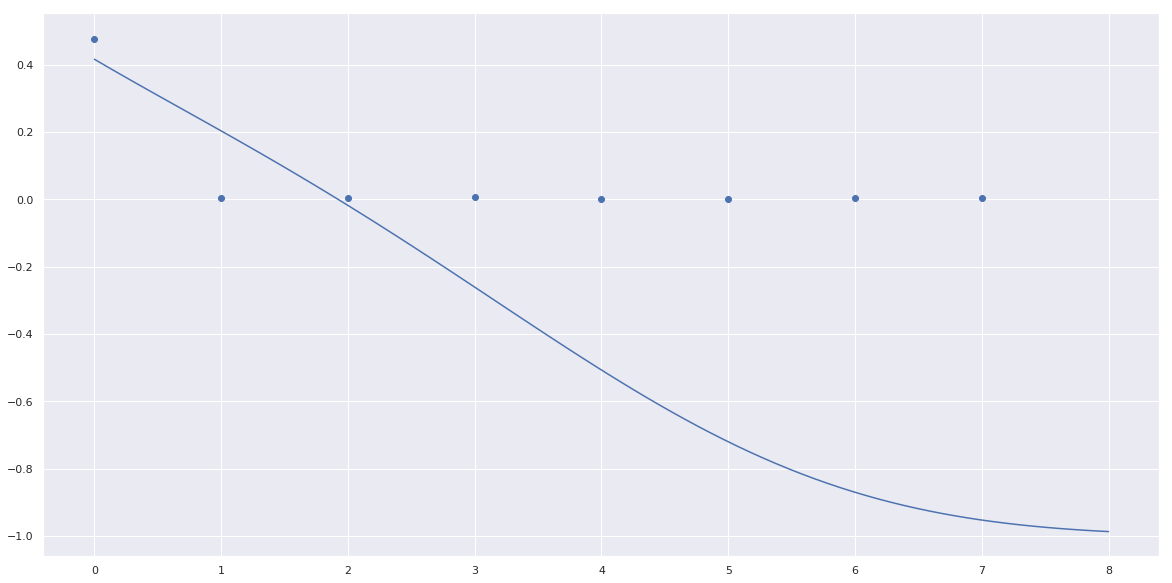

In [320]:
f,ax = plt.subplots(figsize = (20,10))
plt.scatter(df_date.index,df_date['百分比'])
plt.plot(x,y)

留存率曲线拟合